Data from [Statistical inference with a manifold-constrained RNA velocity model uncovers cell cycle speed modulations.](https://doi.org/10.1038/s41592-024-02471-8)

In [1]:
import numpy as np
from CoPhaser import utils
from CoPhaser.trainer import Trainer
from CoPhaser.loss import Loss
from CoPhaser import plotting
from CoPhaser.model import CoPhaser
from CoPhaser import gene_sets
import pickle


import matplotlib.pyplot as plt
import seaborn as sns

import anndata
import scanpy as sc

import pandas as pd

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
DATA_FOLDER = "../../../data/"
adata = anndata.read_h5ad(f"{DATA_FOLDER}cellcycle_maxine/RPE_37C_Rep1_full.h5ad")
# adata = anndata.read_h5ad("../data/cellcycle_maxine/different_cell_types/phase_VASA.h5ad")
adata

AnnData object with n_obs × n_vars = 5865 × 36591
    obs: 'batch'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [4]:
adata = anndata.concat(
    [adata, anndata.read_h5ad(f"{DATA_FOLDER}cellcycle_maxine/RPE_37C_Rep2_full.h5ad")]
)

/home/maxine/miniconda3/envs/CoPhaser_Env/lib/python3.13/site-packages/anndata/_core/anndata.py:1806: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [5]:
adata.obs_names_make_unique()

In [6]:
adata.layers["spliced"] = adata.layers["spliced"].astype("uint16")
adata.layers["unspliced"] = adata.layers["unspliced"].astype("uint16")

In [7]:
adata = adata[:, ~adata.var_names.duplicated()].copy()

In [8]:
sc.pp.filter_genes(adata, min_cells=10)

In [9]:
# create a new layer copy of the spliced layer
adata.layers["s_norm"] = adata.layers["spliced"].copy()
adata.layers["u_norm"] = adata.layers["unspliced"].copy()

# normalize the spliced layer, adding layer option, indicates which layer we want to normalize
sc.pp.normalize_total(adata, target_sum=1e4, layer="s_norm")
sc.pp.normalize_total(adata, target_sum=1e4, layer="u_norm")

# copy the normalized layer to a new layer, s_log
adata.layers["s_log"] = adata.layers["s_norm"].copy()
adata.layers["u_log"] = adata.layers["u_norm"].copy()

# log transform the normalized layer
sc.pp.log1p(adata, layer="s_log")
sc.pp.log1p(adata, layer="u_log")
# add % unspliced to adata.obs
adata.obs["s_counts"] = adata.layers["spliced"].sum(axis=1)
adata.obs["u_counts"] = adata.layers["unspliced"].sum(axis=1)

adata.obs["percent_unspliced"] = adata.obs["u_counts"] / (
    adata.obs["u_counts"] + adata.obs["s_counts"]
)

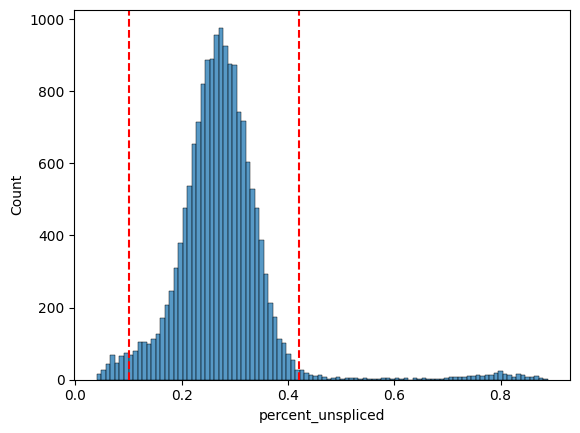

In [10]:
# plot distribution of % unspliced
sns.histplot(adata.obs["percent_unspliced"], bins=100)
# lower threshold for % unspliced
low_percent_unspliced = 0.1
# upper threshold for % unspliced
high_percent_unspliced = 0.42
plt.axvline(low_percent_unspliced, color="red", linestyle="--")
plt.axvline(high_percent_unspliced, color="red", linestyle="--")

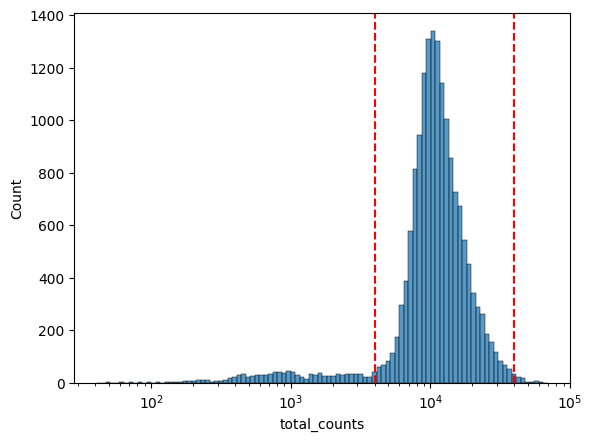

In [11]:
# add total counts to adata.obs
adata.obs["total_counts"] = adata.layers["spliced"].sum(
    axis=1
)  # + adata.layers["unspliced"].sum(axis=1)
# plot distribution of total counts
sns.histplot(adata.obs["total_counts"], bins=100, log_scale=True)
# lower threshold for total counts
low_total_counts = 4000
# upper threshold for total counts
high_total_counts = 40000
plt.axvline(low_total_counts, color="red", linestyle="--")
plt.axvline(high_total_counts, color="red", linestyle="--")

In [12]:
# filter cells based on thresholds
adata = adata[
    (adata.obs["percent_unspliced"] > low_percent_unspliced)
    & (adata.obs["percent_unspliced"] < high_percent_unspliced)
    & (adata.obs["total_counts"] > low_total_counts)
    & (adata.obs["total_counts"] < high_total_counts)
].copy()

In [13]:
adata.obs

batch  s_counts  u_counts  percent_unspliced  \
CellID                                                                   
AAACCCACAAATTGGAx  RPE_37C_Rep1      9133      2155           0.190911   
AAACCCACAAGTAGTAx  RPE_37C_Rep1      8404      2950           0.259820   
AAACCCAGTCTGTGGCx  RPE_37C_Rep1      8828      3323           0.273475   
AAACGAACATCCAACAx  RPE_37C_Rep1     13362      1887           0.123746   
AAACGAATCGTCTCACx  RPE_37C_Rep1      4594      2089           0.312584   
...                         ...       ...       ...                ...   
TTTGGTTTCGTGGTATx  RPE_37C_Rep2     12450      5077           0.289667   
TTTGGTTTCTAACACGx  RPE_37C_Rep2      9981      4365           0.304266   
TTTGGTTTCTTTGATCx  RPE_37C_Rep2      5195      2196           0.297118   
TTTGTTGCACGGTGTCx  RPE_37C_Rep2      7878      4131           0.343992   
TTTGTTGTCCTACCACx  RPE_37C_Rep2      9967      4055           0.289188   

                   total_counts  
CellID                           
AAACCCACAAATTGGAx          9133  
AAACCCACAAGTAGTAx          8404  
AAACCCAGTCTGTGGCx          8828  
AAACGAACATCCAACAx         13362  
AAACGAATCGTCTCACx          4594  
...                         ...  
TTTGGTTTCGTGGTATx         12450  
TTTGGTTTCTAACACGx          9981  
TTTGGTTTCTTTGATCx          5195  
TTTGTTGCACGGTGTCx          7878  
TTTGTTGTCCTACCACx          9967  

[15237 rows x 5 columns]

In [14]:
adata_all_genes = adata.copy()
layer_to_use = "spliced"
library_size = adata_all_genes.layers[layer_to_use].sum(axis=1).A1

In [15]:
adata.X = adata.layers["spliced"].copy()  # + adata.layers["unspliced"]

In [16]:
# Preprocess data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [17]:
SMALL_CYCLING_GENE_SET = gene_sets.SMALL_CELL_CYCLE_GENE_SET
SMALL_CYCLING_GENE_SET = [x.upper() for x in SMALL_CYCLING_GENE_SET]
adata = adata[:, adata.var_names.isin(SMALL_CYCLING_GENE_SET)]

In [18]:
len(SMALL_CYCLING_GENE_SET)

98

In [19]:
# mean center the adata
adata.X = adata.X - adata.X.mean(axis=1)

/tmp/ipykernel_364602/1782500935.py:2: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  adata.X = adata.X - adata.X.mean(axis=1)
/home/maxine/miniconda3/envs/CoPhaser_Env/lib/python3.13/site-packages/anndata/_core/anndata.py:636: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
/tmp/ipykernel_364602/1782500935.py:2: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  adata.X = adata.X - adata.X.mean(axis=1)
/home/maxine/miniconda3/envs/CoPhaser_Env/lib/python3.13/site-packages/scipy/sparse/_index.py:201: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  sel

/home/maxine/miniconda3/envs/CoPhaser_Env/lib/python3.13/site-packages/scanpy/preprocessing/_pca/__init__.py:384: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = x_pca


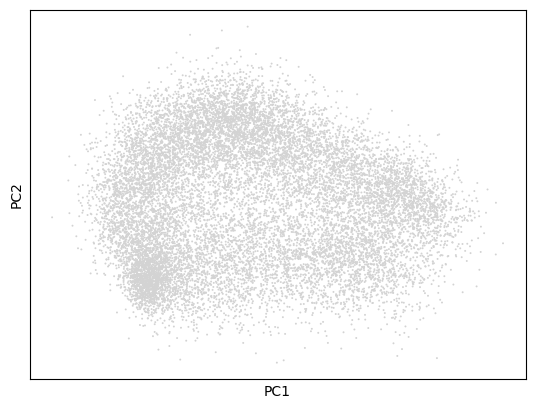

In [20]:
# pca on the data
sc.pp.pca(adata)
# plot the pca
sc.pl.pca(adata)

In [21]:
# add PCA theta to adata.obs
adata.obs["pca_theta"] = np.arctan2(
    adata.obsm["X_pca"][:, 1], adata.obsm["X_pca"][:, 0]
)
adata_all_genes.obs["pca_theta"] = adata.obs["pca_theta"].copy()
adata = adata_all_genes.copy()

<Axes: ylabel='Frequency'>

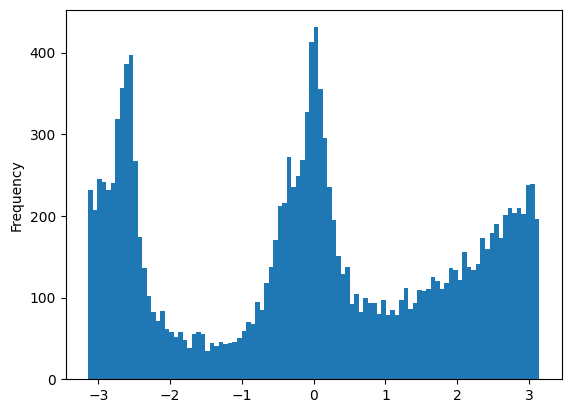

In [22]:
adata.obs["pca_theta"].plot.hist(bins=100)

In [23]:
g = utils.get_variable_genes(adata)
len(g)

2000

In [24]:
adata.obs

batch  s_counts  u_counts  percent_unspliced  \
CellID                                                                   
AAACCCACAAATTGGAx  RPE_37C_Rep1      9133      2155           0.190911   
AAACCCACAAGTAGTAx  RPE_37C_Rep1      8404      2950           0.259820   
AAACCCAGTCTGTGGCx  RPE_37C_Rep1      8828      3323           0.273475   
AAACGAACATCCAACAx  RPE_37C_Rep1     13362      1887           0.123746   
AAACGAATCGTCTCACx  RPE_37C_Rep1      4594      2089           0.312584   
...                         ...       ...       ...                ...   
TTTGGTTTCGTGGTATx  RPE_37C_Rep2     12450      5077           0.289667   
TTTGGTTTCTAACACGx  RPE_37C_Rep2      9981      4365           0.304266   
TTTGGTTTCTTTGATCx  RPE_37C_Rep2      5195      2196           0.297118   
TTTGTTGCACGGTGTCx  RPE_37C_Rep2      7878      4131           0.343992   
TTTGTTGTCCTACCACx  RPE_37C_Rep2      9967      4055           0.289188   

                   total_counts  pca_theta  
CellID                                      
AAACCCACAAATTGGAx          9133  -2.591439  
AAACCCACAAGTAGTAx          8404  -3.031984  
AAACCCAGTCTGTGGCx          8828  -1.862425  
AAACGAACATCCAACAx         13362  -2.828959  
AAACGAATCGTCTCACx          4594  -2.282640  
...                         ...        ...  
TTTGGTTTCGTGGTATx         12450  -2.923701  
TTTGGTTTCTAACACGx          9981   2.829324  
TTTGGTTTCTTTGATCx          5195  -2.326211  
TTTGTTGCACGGTGTCx          7878  -1.673190  
TTTGTTGTCCTACCACx          9967  -2.691984  

[15237 rows x 6 columns]

<Axes: ylabel='Proportion'>

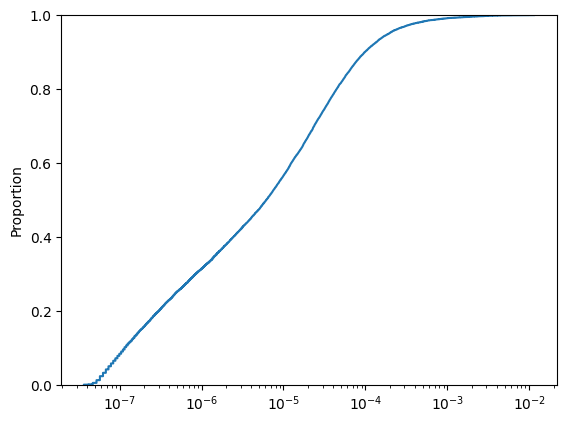

In [25]:
# look at gene fractions distribution
gene_fractions = adata.X.sum(axis=0).A1 / adata.X.sum()
sns.ecdfplot(gene_fractions, log_scale=True)

<Axes: ylabel='Count'>

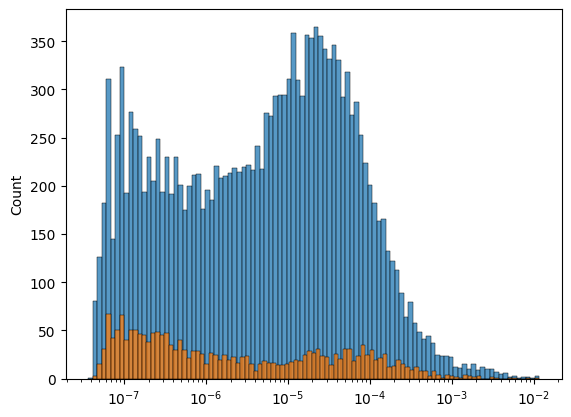

In [26]:
sns.histplot(gene_fractions, bins=100, log_scale=True)
# histplot of the highly variable genes (g)
sns.histplot(gene_fractions[adata.var_names.isin(g)], bins=100, log_scale=True)

Epoch 1/200, elbo_loss: 1990.4581, kl_div_f: 4.6789, kl_div_z: 24.8363, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -2.0307, entropy_loss: -406.1403, radial_variance: 4.7913, radius: 17.7651, L1_mu_z: 0.0000, MI_loss: 0.0000, total_loss: 1606.8742
Epoch 2/200, elbo_loss: 1202.8647, kl_div_f: 4.6279, kl_div_z: 8.2440, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -2.4481, entropy_loss: -489.6152, radial_variance: 14.3565, radius: 47.8178, L1_mu_z: 0.0000, MI_loss: 0.0000, total_loss: 775.4252
Epoch 3/200, elbo_loss: 1172.0287, kl_div_f: 4.5665, kl_div_z: 8.2300, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -2.6504, entropy_loss: -530.0749, radial_variance: 8.3479, radius: 20.9646, L1_mu_z: 0.0000, MI_loss: -0.0000, total_loss: 671.2610
Epoch 4/200, elbo_loss: 1158.9185, kl_div_f: 4.5021, kl_div_z: 8.2561, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -2.8589, en

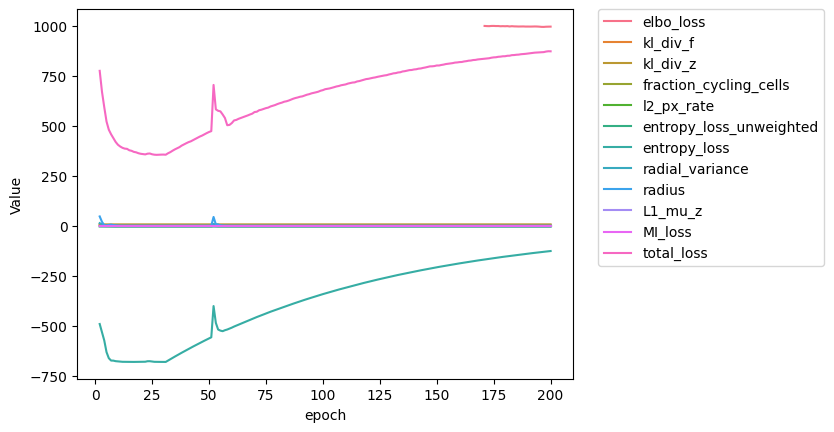

In [27]:
model = CoPhaser(
    SMALL_CYCLING_GENE_SET,
    g,
    n_latent=2,
)
model.load_anndata(adata, layer_to_use="spliced")
trainer = Trainer(
    model,
    Loss.compute_loss,
    noise_model="NB",
    non_rhythmic_likelihood_weight=1,
    rhythmic_likelihood_weight=1,
    L2_Z_decoder_loss_weight=0,
    closed_circle_weight=10,
    cycling_status_prior=1,
    MI_weight=150,
    entropy_weight_factor=200,
    MI_detach="f",
)
trainer.train_model(
    n_epochs=200,
    lr=1e-2,
    device="cuda",
    batch_size=2048,
)

<Axes: ylabel='Count'>

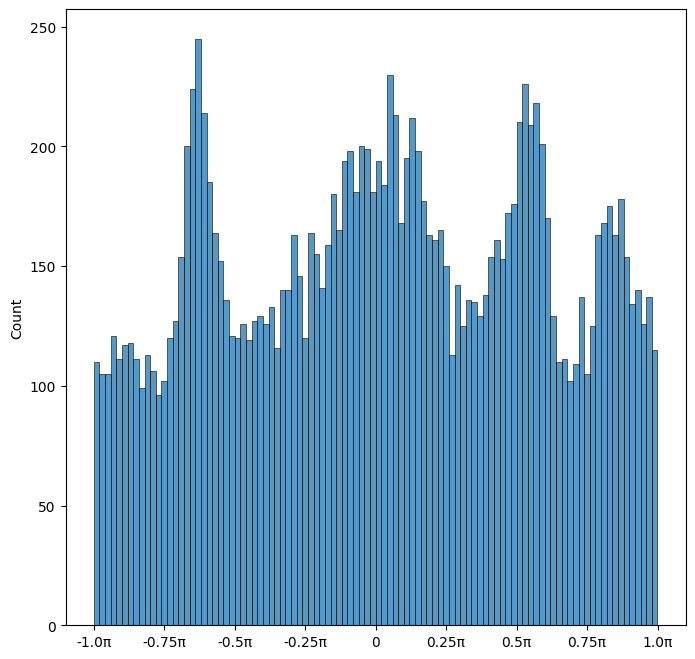

In [28]:
# Get the infered theta values
model.to("cpu")
generative_outputs, space_outputs = model.get_outputs()
thetas = space_outputs["theta"]
plotting.modify_axis_labels()
sns.histplot(thetas, bins=100)

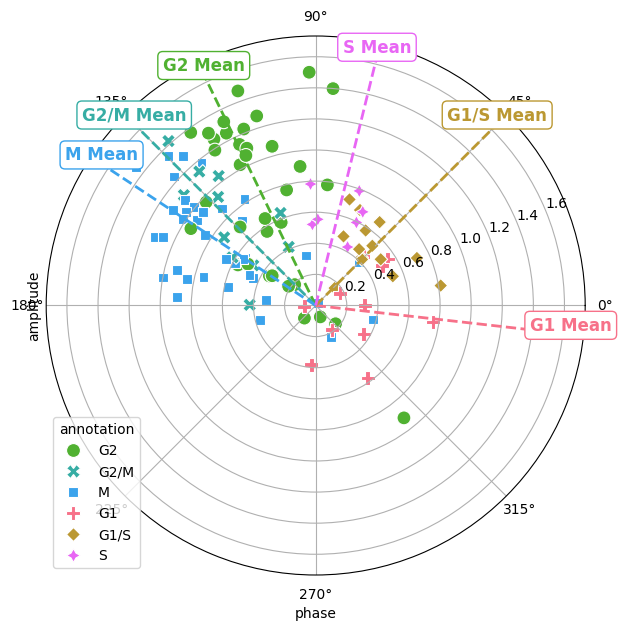

In [29]:
thetas = model.infer_pseudotimes(adata, "spliced", True)

<Axes: >

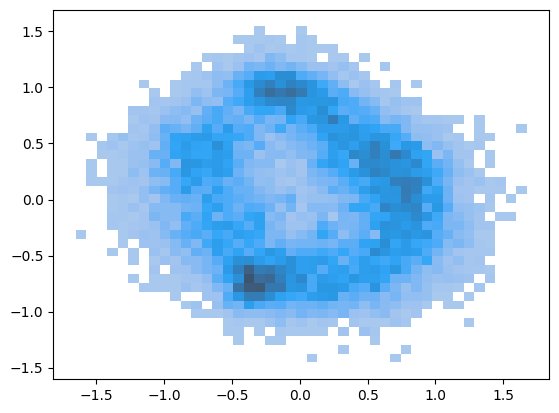

In [30]:
cells_projected = space_outputs["x_projected"].detach().numpy()
sns.histplot(x=cells_projected[:, 0], y=cells_projected[:, 1])

In [31]:
f_coeffs = model.rhythmic_decoder.fourier_coefficients.weight[
    model.rhythmic_gene_indices
]
coeffs = pd.DataFrame(
    f_coeffs.detach().cpu().numpy(),
    columns=["A_1", "B_1", "A_2", "B_2", "A_3", "B_3"],
    index=model.rhythmic_gene_names,
)
# coeffs.to_csv("fourier_coeffs.csv")

<Axes: ylabel='Proportion'>

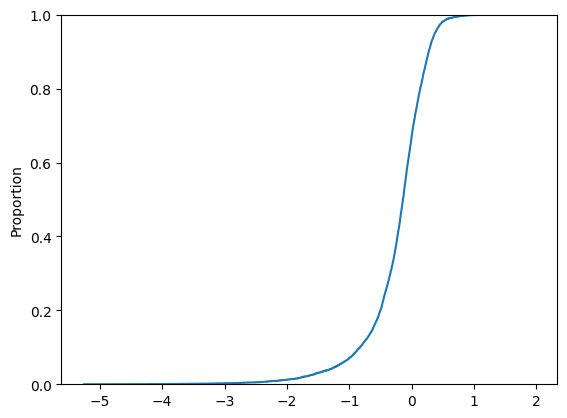

In [32]:
tmp = generative_outputs["Z"].numpy().flatten()
sns.ecdfplot(tmp[np.random.choice(len(tmp), 10000, replace=False)])

In [33]:
def add_theta(df, theta, theta_pca):
    df["inferred_theta"] = theta
    df["pca_theta"] = theta_pca
    return df


df_mean = pd.DataFrame(
    generative_outputs["px_rate"].detach().numpy(), columns=model.context_genes
)
df_mean = add_theta(df_mean, thetas, adata.obs["pca_theta"].values)
# df_rhythmic = pd.DataFrame(generative_outputs["rhythmic_term"].detach().numpy(), columns=model.rhythmic_gene_names)
df_rhythmic = pd.DataFrame(
    generative_outputs["F"].detach().numpy(), columns=model.context_genes
)
df_rhythmic = add_theta(df_rhythmic, thetas, adata.obs["pca_theta"].values)
df_z = pd.DataFrame(
    generative_outputs["Z"].detach().numpy(), columns=model.context_genes
)
df_z = add_theta(df_z, thetas, adata.obs["pca_theta"].values)

[Text(0.5, 0, 'Inferred θ'), Text(0, 0.5, 'PCA θ')]

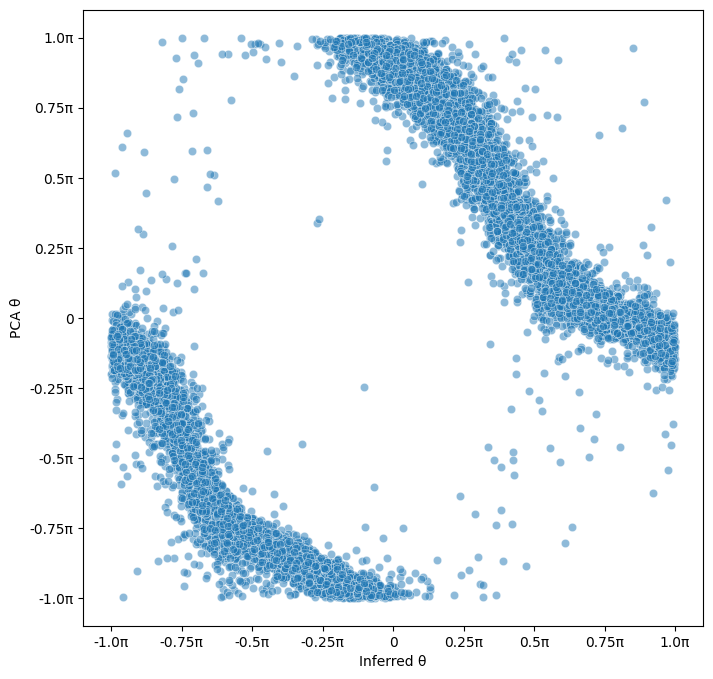

In [34]:
fig, ax = plotting.modify_axis_labels(axis="both")
sns.scatterplot(x=thetas, y=adata.obs["pca_theta"].values, alpha=0.5).set(
    xlabel="Inferred θ", ylabel="PCA θ"
)

/home/maxine/Documents/paychere/CoPhaser/src/CoPhaser/plotting.py:548: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i].legend(loc="upper left", bbox_to_anchor=(1, 1))


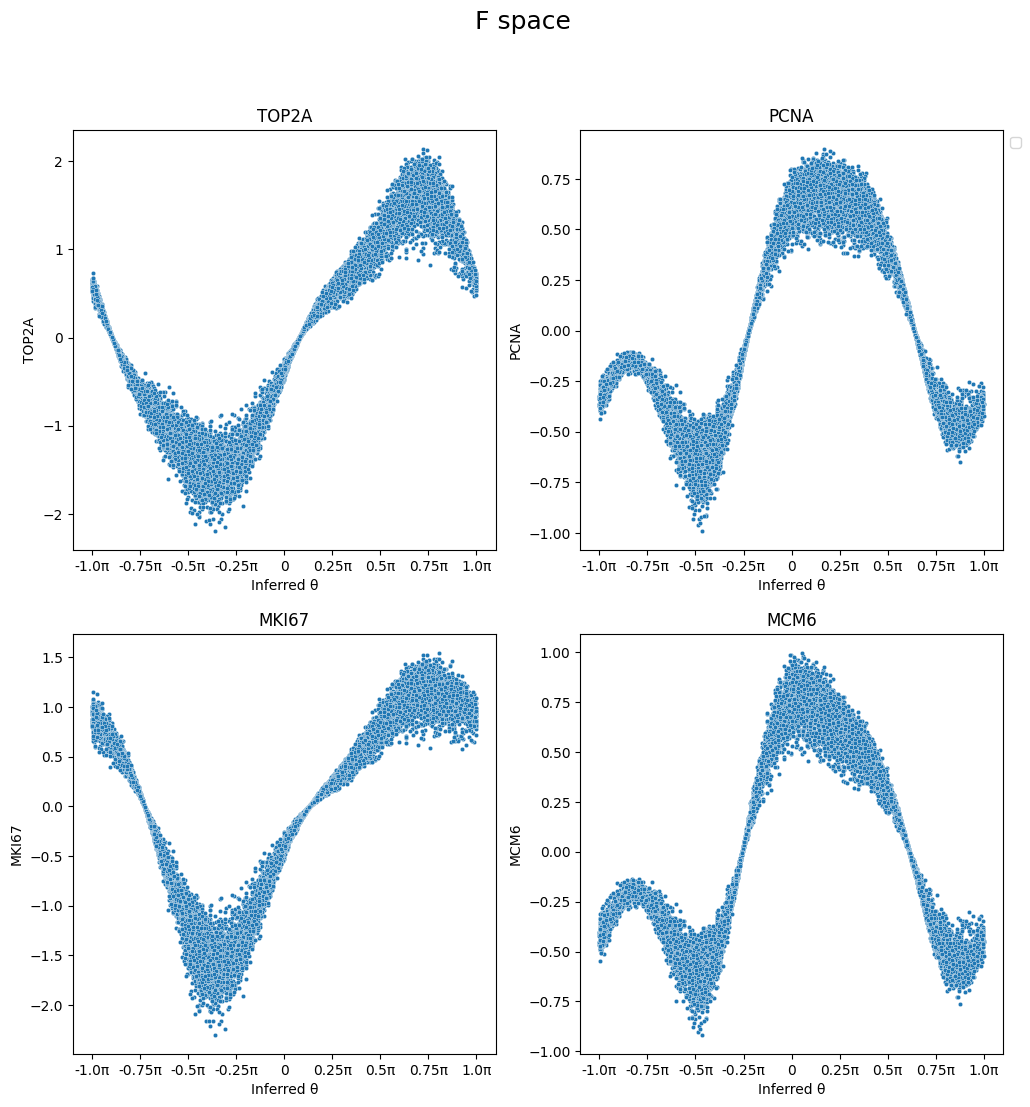

In [35]:
plotting.plot_model_decoded_space(df_rhythmic, gene_to_upper=True, title="F space")

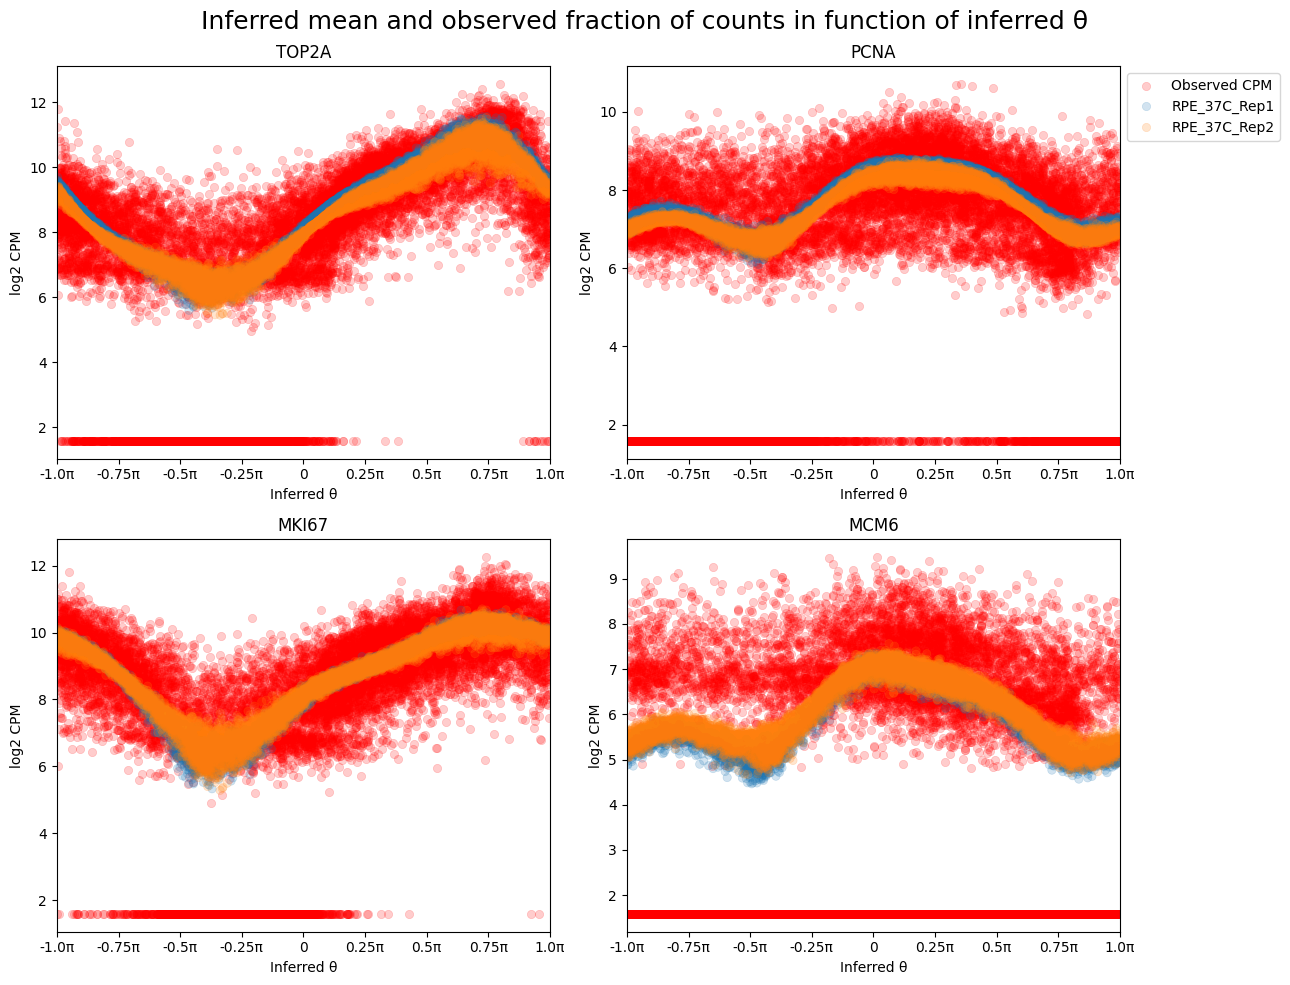

In [36]:
plotting.plot_gene_profile(
    df_mean,
    adata,
    layer_to_use="spliced",
    library_size=library_size,
    hue=adata.obs["batch"].astype("category").values,
    alpha=0.2,
)

In [37]:
adata.obs["library_size"] = library_size
adata.obs["inferred_theta"] = df_mean["inferred_theta"].to_numpy()

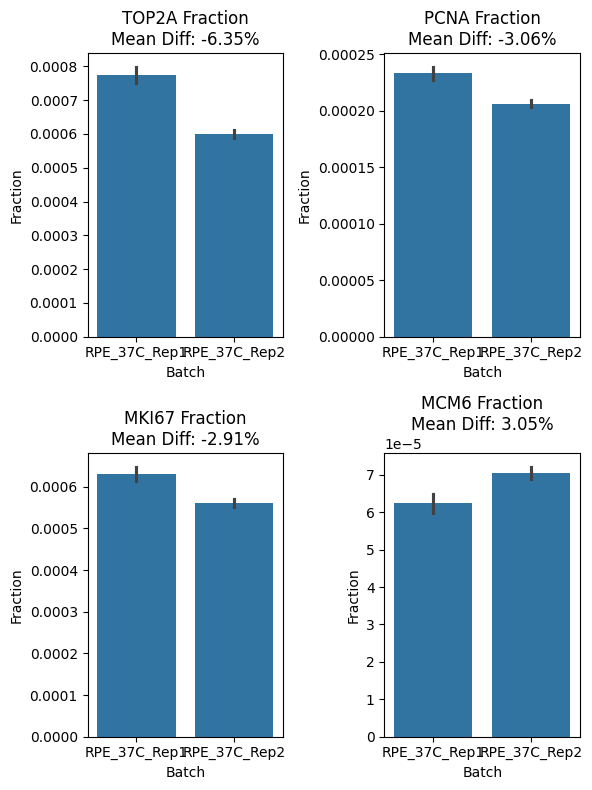

In [38]:
# Calculate the library size
from CoPhaser import gene_sets

# Compute the fractions for selected genes
genes = ["TOP2A", "PCNA", "MKI67", "MCM6"]
fractions = adata[:, genes].layers["spliced"] / library_size[:, None]

# Convert fractions to a dense array
fractions_dense = fractions.toarray()

# Convert to a DataFrame for easier plotting
fractions_df = pd.DataFrame(fractions_dense, columns=genes, index=adata.obs.index)
fractions_df["batch"] = adata.obs["batch"].values  # Add batch information

# Create subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6, 8))
axs = axs.flatten()

# Plot gene fractions for each gene in separate subplots
for i, gene in enumerate(genes):
    # Calculate mean for each batch
    mean_batch_1 = fractions_df.loc[
        fractions_df["batch"] == "RPE_37C_Rep2", gene
    ].mean()
    mean_batch_0 = fractions_df.loc[
        fractions_df["batch"] == "RPE_37C_Rep1", gene
    ].mean()

    # Compute normalized difference
    normalized_diff = (
        (mean_batch_1 - mean_batch_0) / (mean_batch_1 + mean_batch_0) / 2 * 100
    )
    sns.barplot(
        data=fractions_df,
        x="batch",
        y=gene,
        ax=axs[i],
    )
    axs[i].set_title(f"{gene} Fraction\nMean Diff: {normalized_diff:.2f}%")
    axs[i].set_ylabel("Fraction")
    axs[i].set_xlabel("Batch")

# Adjust layout
plt.tight_layout()
plt.show()

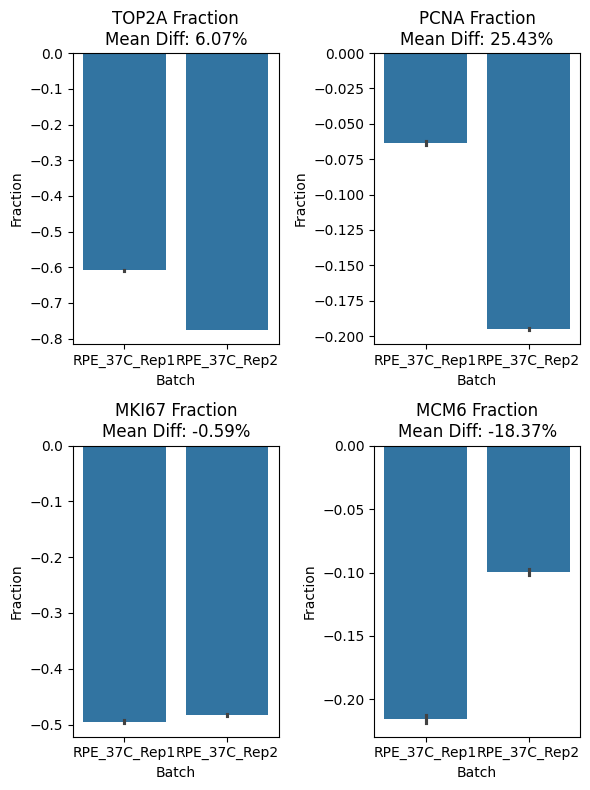

In [39]:
df_z["batch"] = adata.obs["batch"].values

# Create subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6, 8))
axs = axs.flatten()

# Plot gene fractions for each gene in separate subplots
for i, gene in enumerate(genes):
    # Calculate mean for each batch
    mean_batch_1 = df_z.loc[df_z["batch"] == "RPE_37C_Rep2", gene].mean()
    mean_batch_0 = df_z.loc[df_z["batch"] == "RPE_37C_Rep1", gene].mean()

    # Compute normalized difference
    normalized_diff = (
        (mean_batch_1 - mean_batch_0) / (mean_batch_1 + mean_batch_0) / 2 * 100
    )

    # Create barplot
    sns.barplot(
        data=df_z,
        x="batch",
        y=gene,
        ax=axs[i],
    )

    # Set title with normalized difference
    axs[i].set_title(f"{gene} Fraction\nMean Diff: {normalized_diff:.2f}%")
    axs[i].set_ylabel("Fraction")
    axs[i].set_xlabel("Batch")

# Adjust layout
plt.tight_layout()
plt.show()

/tmp/ipykernel_364602/4961845.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df.groupby(["theta_bin", "batch"])["expression"].mean().unstack()
/tmp/ipykernel_364602/4961845.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df.groupby(["theta_bin", "batch"])["expression"].mean().unstack()
/tmp/ipykernel_364602/4961845.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df.grou

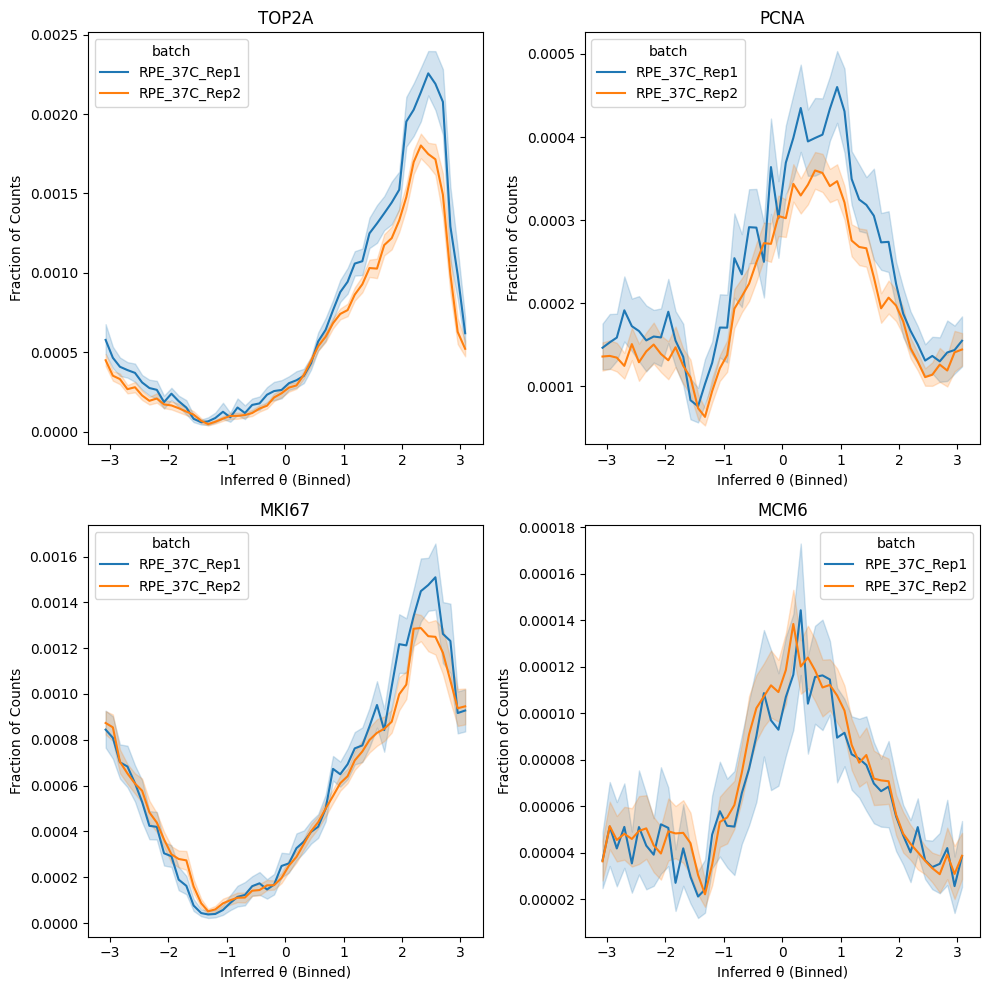

In [40]:
def plot_gene_profile(
    adata,
    genes=["Top2a", "Pcna", "Mki67", "Mcm6"],
    layer_to_use="total",
    ncols=2,
    gene_to_upper=True,
    library_size=None,
    n_bins=50,  # Number of bins for inferred θ
):
    # Determine grid size
    nrows = np.ceil(len(genes) / ncols).astype(int)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 5 * nrows))
    axs = axs.flatten()

    # Convert gene names to uppercase if needed
    if gene_to_upper:
        genes = [gene.upper() for gene in genes]

    # Calculate library size if not provided
    if library_size is None:
        library_size = adata.layers[layer_to_use].sum(axis=1).A1

    # Extract inferred θ and batch information
    inferred_theta = adata.obs["inferred_theta"].values
    batch = adata.obs["batch"].values

    for i, gene in enumerate(genes):
        if i >= len(axs):
            break  # Skip extra axes

        # Extract expression data for the gene
        expression = (
            adata[:, gene].layers[layer_to_use].toarray().flatten() / library_size
        )

        # Create a DataFrame for plotting
        df = pd.DataFrame(
            {"inferred_theta": inferred_theta, "expression": expression, "batch": batch}
        )

        # Bin inferred θ into `n_bins` bins
        df["theta_bin"] = pd.cut(df["inferred_theta"], bins=n_bins, labels=False)
        df["binned_theta"] = df.groupby("theta_bin")["inferred_theta"].transform("mean")

        # Compute the mean expression in each bin for each batch
        bin_means = df.groupby(["theta_bin", "batch"])["expression"].mean().unstack()

        # Calculate the ratio of batch means for each bin
        # avg_ratio = ((bin_means.iloc[:,1] - bin_means.iloc[:,0]) / (bin_means.iloc[:,1] + bin_means.iloc[:,0])).mean() * 100# Assuming batch labels are 0 and 1
        # print(f"Gene: {gene}, Average Ratio (Batch 1 / Batch 0): {avg_ratio:.3f}")

        # Plot smoothed gene profile using sns.lineplot
        sns.lineplot(
            data=df,
            x="binned_theta",
            y="expression",
            hue="batch",
            ax=axs[i],
        )

        # Set plot labels and title
        axs[i].set(
            xlabel="Inferred θ (Binned)", ylabel="Fraction of Counts", title=f"{gene}"
        )

    # Adjust layout
    plt.tight_layout()
    plt.show()


plot_gene_profile(adata, layer_to_use="spliced")

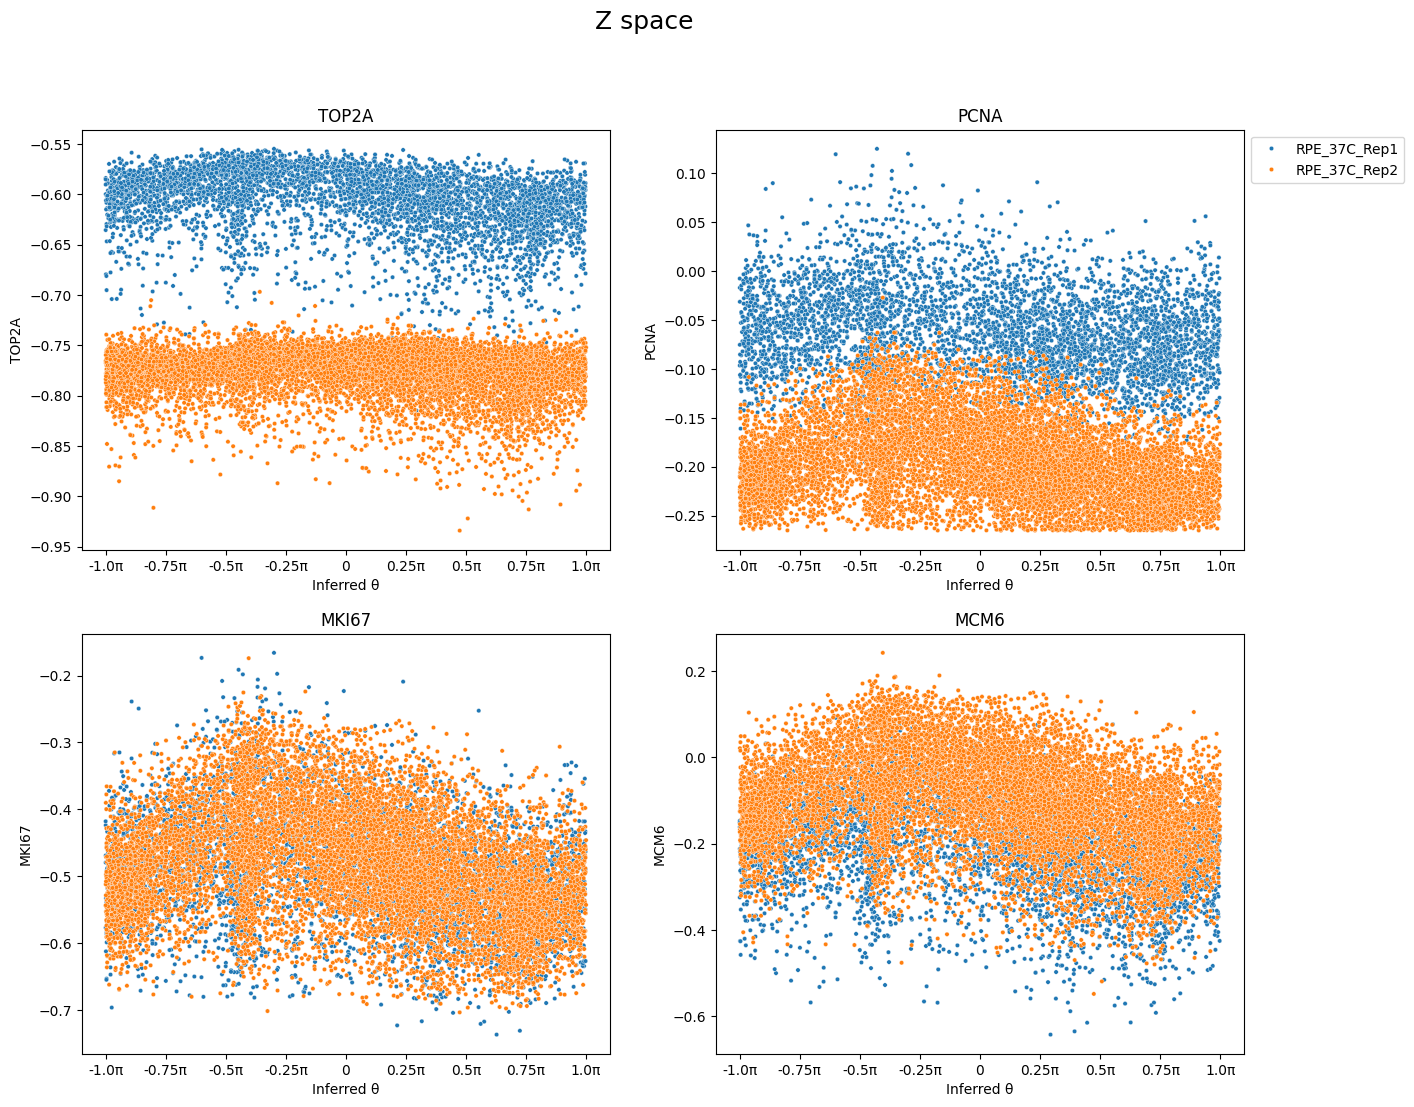

In [41]:
plotting.plot_model_decoded_space(
    df_z, title="Z space", hue=adata.obs["batch"].astype("category").values
)

In [42]:
mean_cyclic_genes = model.mean_genes[model.rhythmic_gene_indices].cpu().numpy()
mean_c = (
    generative_outputs["Z"][adata.obs["batch"].str.endswith("2").values][
        :, model.rhythmic_gene_indices
    ]
    .detach()
    .numpy()
)
mean_cyclic_genes += np.mean(mean_c, axis=0)
coeffs["A_0"] = mean_cyclic_genes
coeffs

A_1       B_1       A_2       B_2       A_3       B_3        A_0
ANLN   -0.089566  0.861236  0.198577 -0.112070 -0.076880 -0.034912  -8.796168
ANP32E -0.167499  0.265755  0.048982 -0.087266 -0.082193 -0.030887  -8.788717
ATAD2   0.609008  0.288758  0.263421 -0.224259 -0.159008  0.024047  -9.220195
AURKA  -0.366223  1.413617  0.098455 -0.254013 -0.031024  0.030696  -9.394581
AURKB   0.385479  1.188922  0.142627 -0.159105  0.028935  0.001725 -10.415741
...          ...       ...       ...       ...       ...       ...        ...
UBR7    0.414408  0.240678  0.014814 -0.085498 -0.005937 -0.001296 -10.549568
UHRF1   0.285908  0.135790  0.160032 -0.294359 -0.085447 -0.023146 -10.039370
UNG     0.529061 -0.547507  0.294519 -0.109551 -0.172493  0.025887 -10.252223
USP1    0.535011  0.260249  0.045362 -0.214958 -0.131173  0.024610  -8.785173
WDR76   0.506818 -0.156554  0.311074 -0.230439 -0.191282  0.055282  -9.958161

[98 rows x 7 columns]

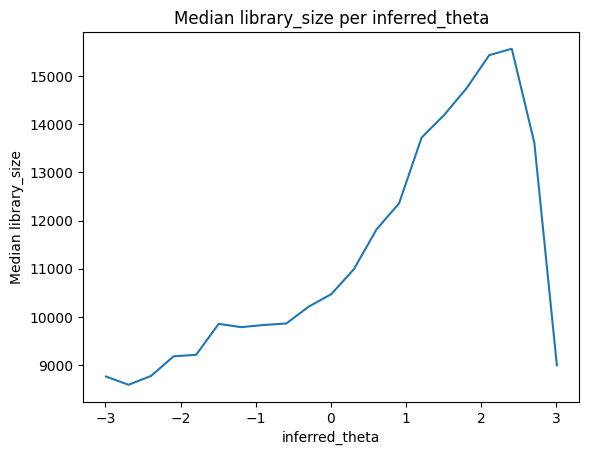

In [43]:
plotting.plot_smoothed_size_evolution(adata, "inferred_theta")

<Axes: xlabel='inferred_theta'>

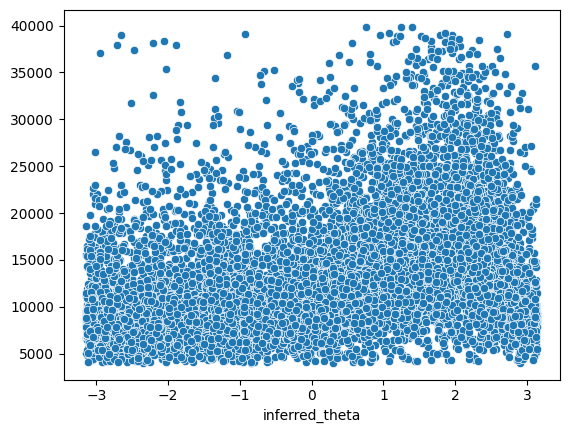

In [44]:
sns.scatterplot(x=df_mean["inferred_theta"], y=library_size)

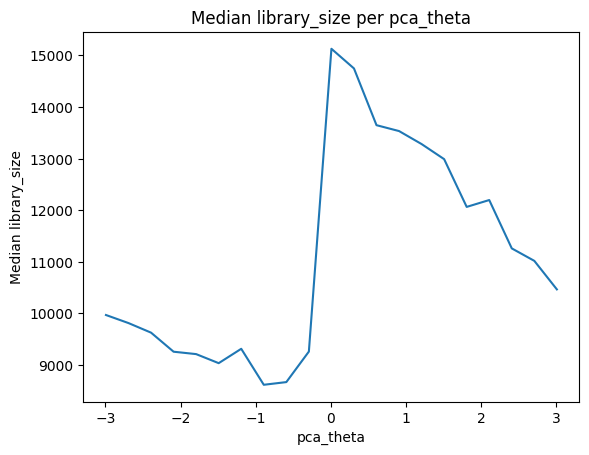

In [45]:
plotting.plot_smoothed_size_evolution(adata, "pca_theta")

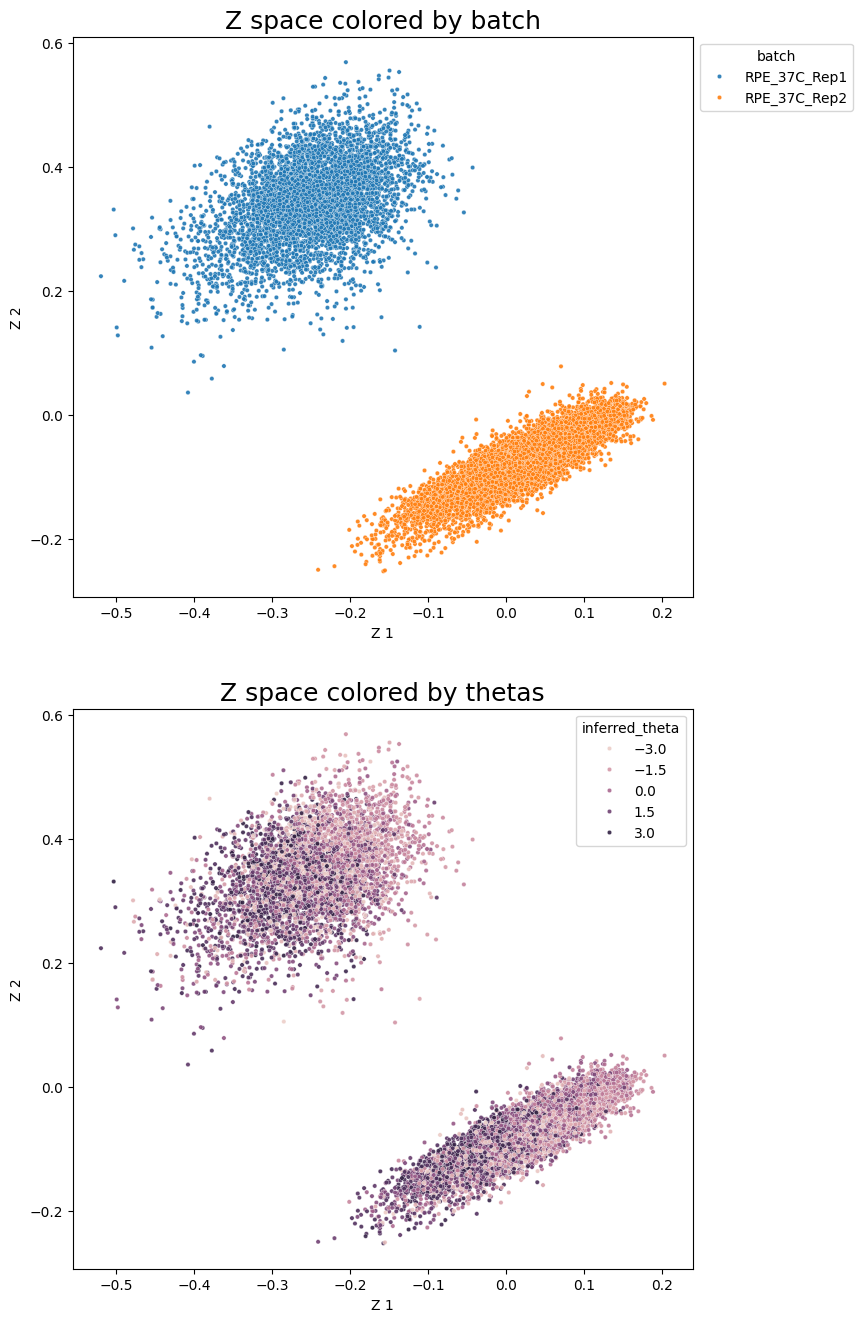

In [46]:
plotting.plot_z_space(
    space_outputs["z"],
    adata.obs["batch"].astype("category"),
    adata.obs["inferred_theta"],
    cell_identity_label="batch",
)

/home/maxine/Documents/paychere/CoPhaser/src/CoPhaser/plotting.py:232: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


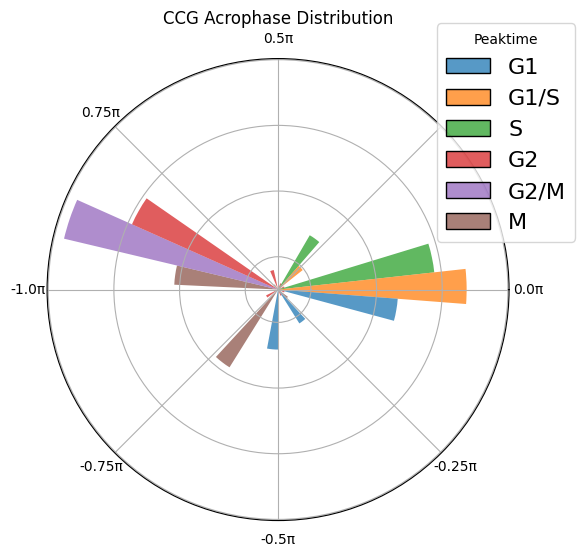

In [47]:
with plt.rc_context({"legend.fontsize": 16}):
    plotting.plot_cell_cycle(df_rhythmic)

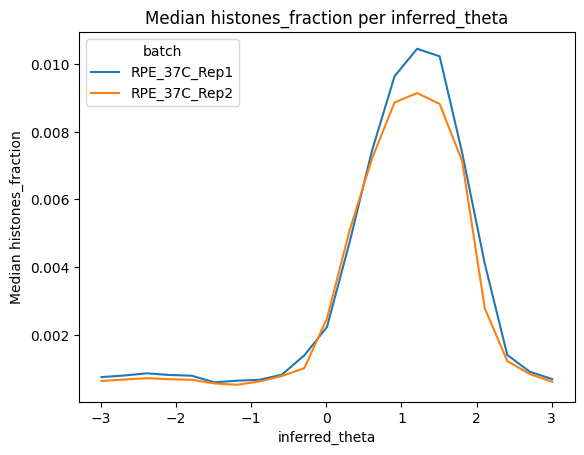

In [48]:
utils.add_histones_fraction(adata=adata, layer="spliced")
plotting.plot_smoothed_size_evolution(
    adata, "inferred_theta", counts_sum_field="histones_fraction", hue="batch"
)

In [49]:
to_save = {}
to_save["library_size"] = adata.obs["library_size"].to_numpy()
to_save["inferred_theta"] = adata.obs["inferred_theta"].to_numpy()
to_save["histones_fraction"] = adata.obs["histones_fraction"].to_numpy()
to_save["cell_indices"] = adata.obs.index.to_numpy()
to_save["z_space"] = {
    "z_1": space_outputs["z"][:, 0].detach().numpy(),
    "z_2": space_outputs["z"][:, 1].detach().numpy(),
}
to_save["df_mean"] = df_mean
to_save["df_rhythmic"] = df_rhythmic
to_save["df_z"] = df_z
to_save["f_space"] = {
    "f_1": cells_projected[:, 0],
    "f_2": cells_projected[:, 1],
}

In [50]:
# pickle.dump(to_save, open("data/rpe_results.pkl", "wb"))